In [ ]:
import torch
from torch.autograd import Variable  # переменная
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
from IPython.display import IFrame
%matplotlib inline

import numpy as np
import imageio   # для генерации GIF изображений

torch.manual_seed(42)

### Генерация обучающего набора

In [ ]:
x = torch.unsqueeze(torch.sort(torch.rand(100))[0], dim=1)
x = x*2 - 1
x_t = torch.unsqueeze(torch.sort(torch.rand(1000))[0], dim=1)
x_t = x_t*2 - 1
y_true = torch.pow(x, 2) # функция pow возводит в квадрат
y_t = torch.pow(x_t, 2)
y = torch.pow(x, 2) + (torch.rand(x.size()) - 0.5)/3   # Делим на 3, чтобы уменьшить влияние шума

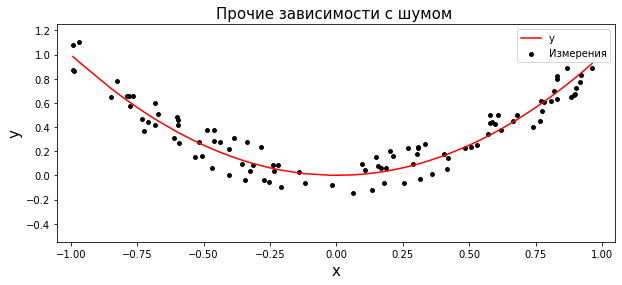

In [ ]:
x, y = Variable(x), Variable(y)

plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color='black', label = 'Измерения', s = 15)
plt.plot(x.data.numpy(), y_true, color = 'red', label = 'y')
plt.title('Прочие зависимости с шумом ', fontdict={'size': 15})
plt.xlabel('x', fontdict={'size': 15})
plt.ylabel('y', fontdict={'size': 15})
plt.xlim(-1.05, 1.05)
plt.ylim(-0.55, 1.25)
plt.legend()
plt.show()

In [ ]:
# Построим многослойный персептрон
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):  # n_hidden - количество скрытых слоев
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden) # записываем преобразование, что внутренний слой принимает
                                                           # на вход выход входного слоя
        self.predict = torch.nn.Linear(n_hidden, n_output) # внутренний слой используем чтобы получить предсказание

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [ ]:
# создаем сеть
net = Net(n_feature=1, n_hidden = 10, n_output=1)
loss_func = torch.nn.MSELoss()

In [ ]:
BATCH_SIZE = 64
EPOCH = 40
torch.dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(        # создаем объект loader, который загружает наш датасет, не за 1 раз а по кусочкам
        dataset=torch.dataset,   # (пакетами), размером с batch, то есть это обучение батчами
        batch_size=BATCH_SIZE,
        shuffle=True, num_workers=2,)

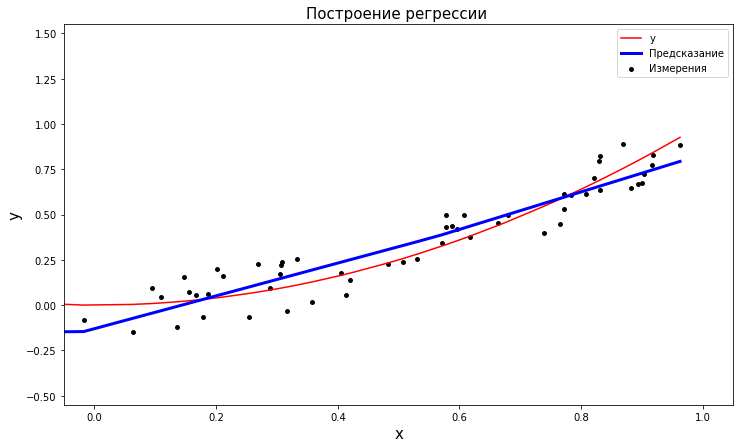

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)  # исп-м Adam, парамеры сети, скорость обучения


my_images = []   # список для текущих предсказаний НС
fig, ax = plt.subplots(figsize=(12, 7))

for epoch in range(EPOCH):     # прогоняем обучение 40 раз
    for step, (batch_x, batch_y) in enumerate(loader):  # делаем батчи и по ним обучаем НС
        b_x = Variable(batch_x) # Вот тут была запятая
        b_y = Variable(batch_y)

        prediction = net(b_x)   # получаем предсказания для всех b_х

        loss = loss_func(prediction, b_y)   # считаем функцию потерь

        prediction = net(x)   # получаем предсказания для всех х

        loss = loss_func(y, prediction)

        optimizer.zero_grad()  # делаем градиентный спуск (обратное распространения ошибки)
        loss.backward()
        optimizer.step()

        plt.cla()
        ax.scatter(x.data.numpy(), y.data.numpy(), color = 'black', label = 'Измерения', s = 15)
        ax.plot(x.data.numpy(), y_true, color = 'red', label = 'y')
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'blue', lw=3, label='Предсказание')

        ax.set_title('Построение регрессии ', fontdict={'size': 15})
        ax.set_xlabel('x', fontdict={'size': 15})
        ax.set_ylabel('y', fontdict={'size': 15})
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.55, 1.55)
        ax.legend()

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)

for _ in range(10):
    my_images.append(image)

#при таком вызове важно создать внутри папки content папку с именем gif
imageio.mimsave('./gif/small_nn.gif', my_images, fps=10)
# в колаб не будет работать. в juputer будет
IFrame(src = './gif/small_nn.gif', width=900, height=550)

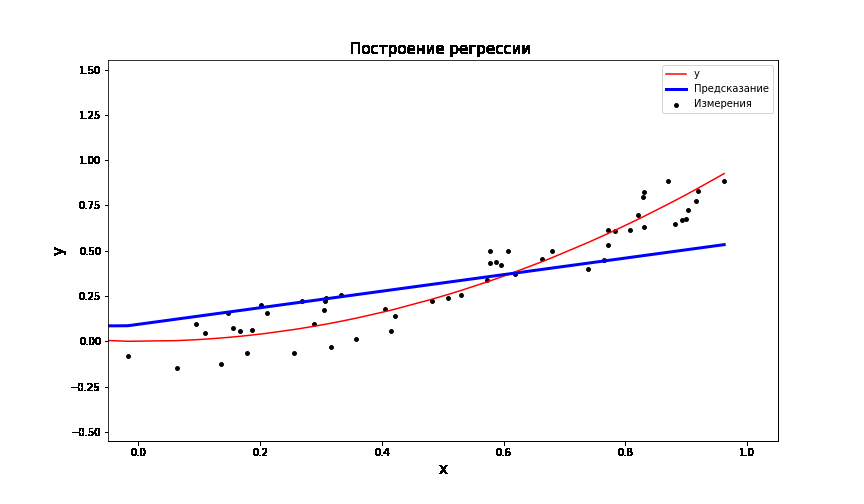

In [ ]:
#Для отображения
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
gifPath = './gif/small_nn.gif'
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')